# # Visualisation and evaluation tools

In this Section, we will demonstrate some tools to visualise how calibrated your models are. We will get some intuition about what correction is applying a calibrator, and some calibration evaluation measures.

In [1]:
%matplotlib inline
%precision 2
import warnings; warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pycalib

np.random.seed(42)

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["savefig.bbox"] = 'tight'
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

from pycalib.metrics import binary_ECE, binary_MCE, conf_ECE, conf_MCE, classwise_ECE, classwise_MCE

# Binary dataset

We will start with a simple binary dataset composed by some blobs. You can change the dataset here to any binary one but the rest of the text assumes the first example is being used.

In [2]:
from sklearn.datasets import make_blobs

dataset_binary = make_blobs(n_samples=10000, centers=5,
                            n_features=2,
                            random_state=42)

dataset_binary[1][:] = dataset_binary[1] > 2

Each dataset is just composed by the features $x$ and labels $y$. The following is a scatterplot of the dataset.

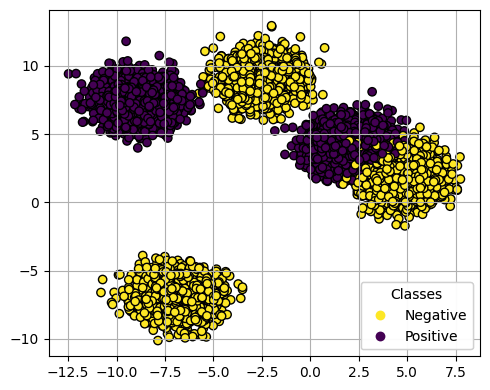

In [3]:
x, y = dataset_binary
fig, ax = plt.subplots()
scatter = ax.scatter(x[:, 0], x[:, 1], c=y, edgecolors= "black", cmap="viridis_r")
handles, labels = scatter.legend_elements()
labels = ['Negative', 'Positive']
legend = ax.legend(handles, labels,
                    loc="lower right", title="Classes")
ax.add_artist(legend)
ax.grid()
plt.tight_layout()

# Reliability diagram

We will first train a classifier and see how calibrated it is with a reliability diagram. We will load first the previously generated binary dataset.

In [4]:
from sklearn.model_selection import train_test_split

x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

Now we will train a binary classifier.

In [5]:
from sklearn.naive_bayes import GaussianNB
clf_bin = GaussianNB()
clf_bin.fit(x_train, y_train)

print('Priors {}'.format(clf_bin.class_prior_))
print('Absolute additive value to the variances {}'.format(clf_bin.epsilon_))
print('Variances {}'.format(clf_bin.sigma_))
print('Mean {}'.format(clf_bin.theta_))

Priors [0.6 0.4]
Absolute additive value to the variances 3.226318807172663e-08
Variances [[23.57 43.55]
 [30.53  3.54]]
Mean [[-1.63  1.34]
 [-3.33  5.76]]


Now, we will check what are the probabilities output by the classifier in the different regions of the feature space. 

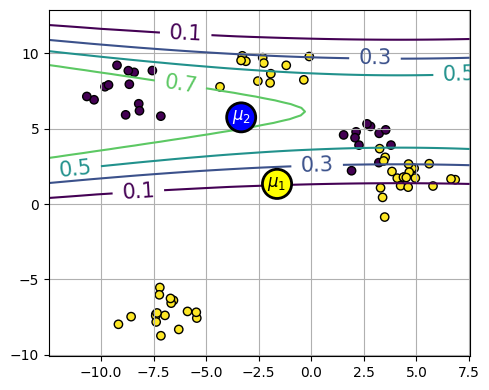

In [6]:
delta = 0.25
x0_grid = np.arange(x[:, 0].min(), x[:, 0].max(), delta)
x1_grid = np.arange(x[:, 1].min(), x[:, 1].max(), delta)
X0, X1 = np.meshgrid(x0_grid, x1_grid)
Y = clf_bin.predict_proba(np.vstack((X0.flatten(), X1.flatten())).T)

fig, ax = plt.subplots()
CS = ax.contour(X0, X1, Y[:, 1].reshape(X0.shape),
                levels=[.1, .3, .5, .7, .9])
ax.clabel(CS, inline=1, fmt='%1.1f', fontsize=15)
ax.scatter(x_test[:75, 0], x_test[:75, 1], c=y_test[:75], edgecolors= "black", cmap="viridis_r")
#ax.set_title('Predicted probabilities')

ax.text(clf_bin.theta_[0][0], clf_bin.theta_[0][1], "$\mu_1$", ha="center", va="center", size=12,
        bbox=dict(boxstyle="circle,pad=0.3", fc="yellow", ec="black", lw=2))
ax.text(clf_bin.theta_[1][0], clf_bin.theta_[1][1], "$\mu_2$", ha="center", va="center", size=12, color='white',
        bbox=dict(boxstyle="circle,pad=0.3", fc="blue", ec="black", lw=2))

ax.grid()
plt.tight_layout()

We can also look at the positive scores given by the classifeir to each test sample. In the following figure we just numbered every instance with an increasing number and we show the corresponding output score. Then on the right we show a histogram of all the scores.

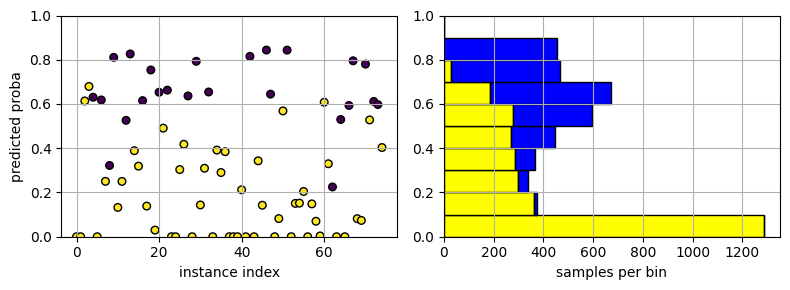

In [7]:
n_bins = 10
bins = np.linspace(0, 1, n_bins+1)

p_clf = clf_bin.predict_proba(x_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.scatter(range(75), p_clf[:75,1], c=y_test[:75], s=30, edgecolor='black', cmap="viridis_r")
ax1.set_ylim(0, 1)
ax1.grid()
ax1.set_xlabel('instance index')
ax1.set_ylabel('predicted proba')
ax2.hist([p_clf[y_test == 0, 1],
          p_clf[y_test == 1, 1]],
         bins=bins, orientation='horizontal', stacked=True,
         color=['yellow', 'blue'], edgecolor='black')
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_xlabel('samples per bin')
plt.tight_layout()
fig.savefig('cal_1_vis_hist.pdf')

We can clearly see that the model gives lower scores to the negative class. We can also see that most of the negative instances are in the range of scores between 0 and 0.1. And notice that the last bin between 0.9 and 1.0 does not contain any sample.

Now, in order to plot the reliability diagram we need to compute the mean scores in each of the bins, as well as the true proportion of positives.

We start by assigning each of the instances to the corresponding bin. The function digitize from Numpy returns the index of the corresponding bin for each instance.

In [8]:
digitized = np.digitize(p_clf[:, 1], bins=bins)
print('Bins = {}'.format(bins))
print(digitized)

Bins = [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[1 1 7 ... 9 1 6]


Now we can compute the mean score in each bin

In [9]:
pred_means = [p_clf[:, 1][digitized == i].mean() for i in range(1, n_bins+1)]
print(pred_means)

[0.012432487052501908, 0.15203439630231722, 0.24868816147980233, 0.35145643469960997, 0.45029774080111806, 0.5534547383794531, 0.6486686394892508, 0.7595789271035308, 0.8238768795804186, nan]


Notice that the last bin does not contain any sample, and thus it is assigned a NaN. Now we compute the true positive rate in each bin (or the average value of zeros and ones).

In [10]:
y_means = [y_test[digitized == i].mean() for i in range(1, n_bins+1)]
print(y_means)

[0.000777000777000777, 0.03208556149732621, 0.11538461538461539, 0.22282608695652173, 0.39461883408071746, 0.5326633165829145, 0.7228017883755589, 0.9419354838709677, 1.0, nan]


We can now plot a line with the mean scores in the $x$ axis and the true positive rate on the $y$ axis. We will also show a histogram with the positive and negative samples per bin.

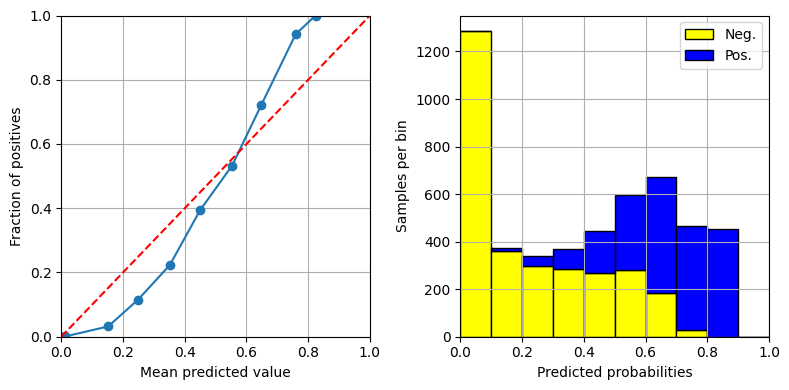

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(pred_means, y_means, 'o-')
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlim(0, 1)
ax1.set_xlabel('Mean predicted value')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Fraction of positives')
ax1.grid()

ax2.hist([p_clf[y_test == 0, 1],
          p_clf[y_test == 1, 1]],
         bins=bins, orientation='vertical', stacked=True,
         color=['yellow', 'b'], edgecolor='black',
         label=['Neg.', 'Pos.'])
ax2.legend()
ax2.set_xlim(0, 1)
ax2.set_xlabel('Predicted probabilities')
ax2.set_ylabel('Samples per bin')
ax2.grid()
plt.tight_layout()
plt.savefig('cal_1_vis_rel_diag_and_hist.pdf')

We can see in the previous reliability diagram that the model is

- over-confident in the lower range of scores: predicts scores of 0.2 when the true proportion of positives is around 10%.
- under-confident in the higher range of scores: predicts scores of 0.8 when the true proportion of positives is 100%.

The red diagonal shows the reliability diagram for a calibrated model which always predicts the true proportion of positives.

We can show the **correction** that should be applied to the scores for the model to be calibrated.

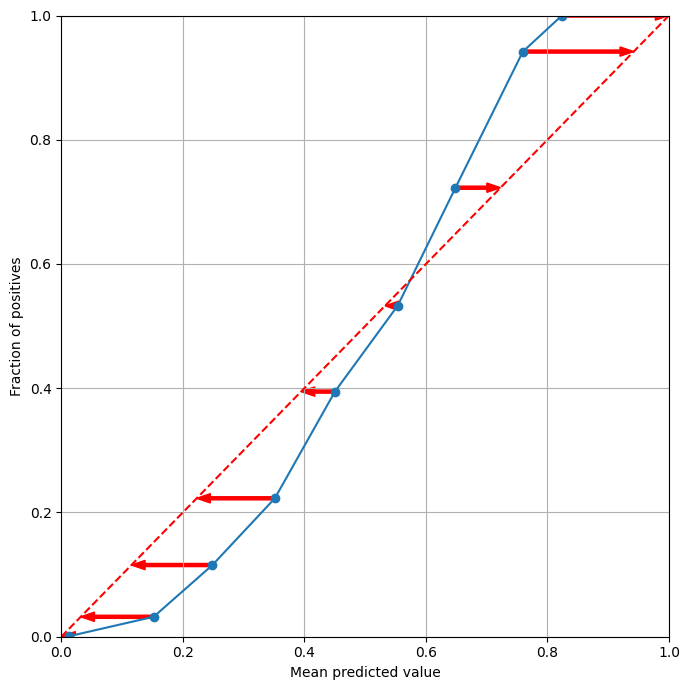

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
ax1.plot(pred_means, y_means, 'o-')
ax1.plot([0, 1], [0, 1], 'r--')

for x, y in zip(pred_means, y_means):
    ax1.arrow(x, y, y-x, y-y, width=0.005, length_includes_head=True, color='red')

ax1.set_xlim(0, 1)
ax1.set_xlabel('Mean predicted value')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Fraction of positives')
ax1.grid()


Lets train a different classifier in order to compare with the previous one

In [14]:
from sklearn.neighbors import KNeighborsClassifier

clf_bin_2 = KNeighborsClassifier(n_neighbors=10)
clf_bin_2.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In the PyCalib library we can directly call a function to plot the reliability diagram for a list of output scores, in this case we will demonstrate with the previously trained classifiers

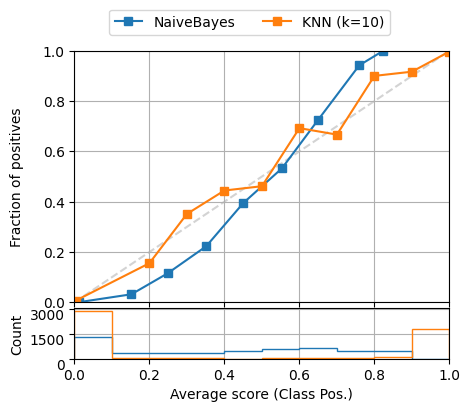

In [15]:
from pycalib.visualisations import plot_reliability_diagram

scores_list = [clf_bin.predict_proba(x_test),
               clf_bin_2.predict_proba(x_test)]

fig = plt.figure()
plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', 'KNN (k=10)'), class_names=['Neg.', 'Pos.'],
                         fig=fig);
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_nb_knn.pdf')

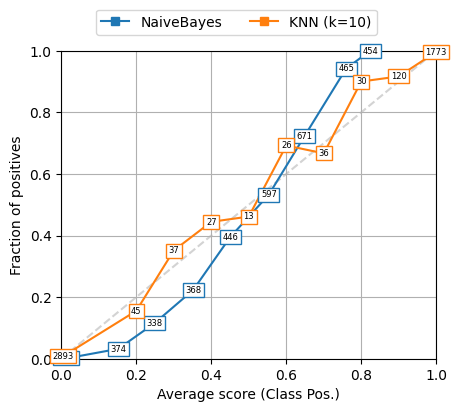

In [16]:
fig = plt.figure()
plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', 'KNN (k=10)'), class_names=['Neg.', 'Pos.'],
                         fig=fig, show_counts=True, show_histogram=False);
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_count_nb_knn.pdf')

In [17]:
help(plot_reliability_diagram)

Help on function plot_reliability_diagram in module pycalib.visualisations:

plot_reliability_diagram(labels, scores, legend=None, show_histogram=True, bins=10, class_names=None, fig=None, show_counts=False, errorbar_interval=None, interval_method='beta', fmt='s-', show_correction=False, show_gaps=False, sample_proportion=0, hist_per_class=False, color_list=None, show_bars=False, invert_histogram=False, color_gaps='lightcoral', confidence=False)
    Plots the reliability diagram of the given scores and true labels
    
    Parameters
    labels : array (n_samples, )
        Labels indicating the true class.
    scores : matrix (n_samples, n_classes) or list of matrices
        Output probability scores for one or several methods.
    legend : list of strings or None
        Text to use for the legend.
    show_histogram : boolean
        If True, it generates an additional figure showing the number of
        samples in each bin.
    bins : int or list of floats
        Number of bins 

In [18]:
clf_bin.predict_proba(x_test)

array([[1.00e+00, 7.62e-08],
       [1.00e+00, 1.72e-10],
       [3.86e-01, 6.14e-01],
       ...,
       [1.64e-01, 8.36e-01],
       [1.00e+00, 3.91e-09],
       [4.26e-01, 5.74e-01]])

In [19]:
print('Naive Bayes bin-ECE = ', binary_ECE(y_test, clf_bin.predict_proba(x_test)[:,1], bins=n_bins))
print('KNN bin-ECE = ', binary_ECE(y_test,  clf_bin_2.predict_proba(x_test)[:,1], bins=n_bins))

print('Naive Bayes bin-MCE = ', binary_MCE(y_test, clf_bin.predict_proba(x_test)[:,1], bins=n_bins))
print('KNN bin-MCE = ', binary_MCE(y_test,  clf_bin_2.predict_proba(x_test)[:,1], bins=n_bins))

print('Naive Bayes conf-ECE = ', conf_ECE(y_test, clf_bin.predict_proba(x_test), bins=n_bins))
print('KNN conf-ECE = ', conf_ECE(y_test,  clf_bin_2.predict_proba(x_test), bins=n_bins))

print('Naive Bayes conf-MCE = ', conf_MCE(y_test, clf_bin.predict_proba(x_test), bins=n_bins))
print('KNN conf-MCE = ', conf_MCE(y_test,  clf_bin_2.predict_proba(x_test), bins=n_bins))

Naive Bayes bin-ECE =  0.08079967025663184
KNN bin-ECE =  0.005960000000000007
Naive Bayes bin-MCE =  0.1823565567674369
KNN bin-MCE =  0.09999999999999976
Naive Bayes conf-ECE =  0.07583467873161782
KNN conf-ECE =  0.00683999999999987
Naive Bayes conf-MCE =  0.16170908776716286
KNN conf-MCE =  0.06666666666666787


We can also see a visualisation that emphasizes the gaps between the proportions of positives of each bin and the perfect diagonal.

In this case we will show it for the first classifier.

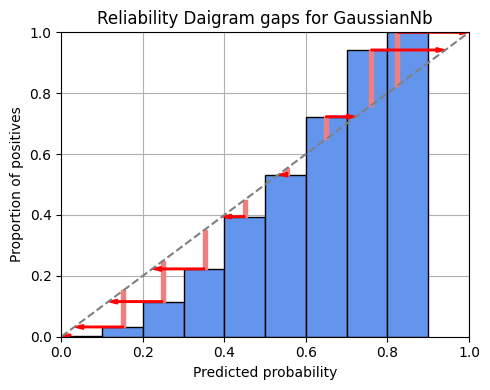

In [20]:
from pycalib.visualisations import plot_binary_reliability_diagram_gaps

est_scores = clf_bin.predict_proba(x_test)

fig, ax = plot_binary_reliability_diagram_gaps(y_test, est_scores, n_bins=10)
_ = ax.set_title('Reliability Daigram gaps for GaussianNb')

for x, y in zip(pred_means, y_means):
    ax.arrow(x, y, y-x, y-y, width=0.005, length_includes_head=True, color='red')


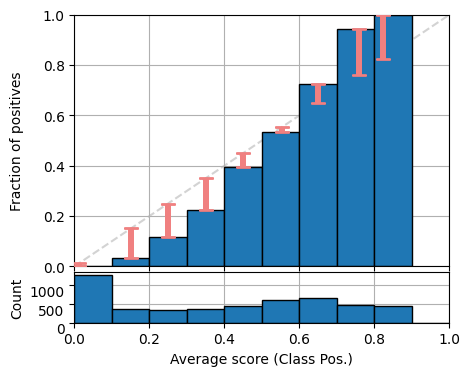

In [21]:
from pycalib.visualisations import plot_binary_reliability_diagram_gaps

est_scores = clf_bin.predict_proba(x_test)

fig = plt.figure()
plot_reliability_diagram(y_test, est_scores, bins=10, show_bars=True, show_gaps=True,
                         class_names=['Neg.', 'Pos.'], fig=fig);
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_bar_gaps.pdf')

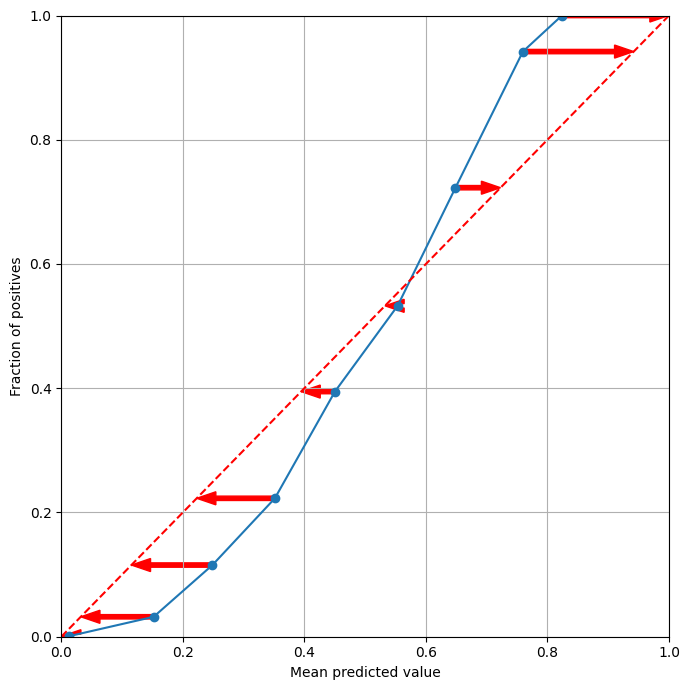

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
ax1.plot(pred_means, y_means, 'o-')
ax1.plot([0, 1], [0, 1], 'r--')

for x, y in zip(pred_means, y_means):
    ax1.arrow(x, y, y-x, y-y, width=0.007, length_includes_head=True, color='red')
    
#for x, y in zip(pred_means, y_means):
#    ax1.arrow(x, y, x-x, x-y, color='red', head_width=None)

ax1.set_xlim(0, 1)
ax1.set_xlabel('Mean predicted value')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Fraction of positives')
ax1.grid()

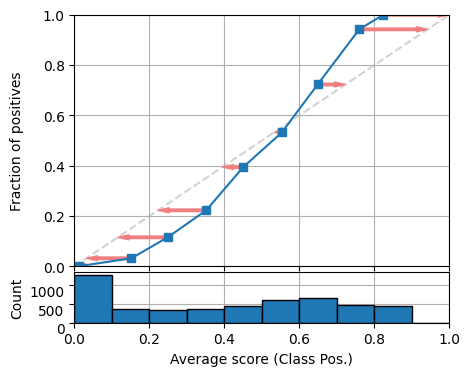

In [23]:
fig = plt.figure()
plot_reliability_diagram(y_test, est_scores, bins=10, show_correction=True, class_names=['Neg.', 'Pos.'],
                        fig=fig);
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_lin_corr.pdf')

We can compute the Expected Calibration Error (ECE)

In [24]:
from pycalib.metrics import ECE, MCE

print('ECE = ', ECE(y_test, est_scores))
print('MCE = ', MCE(y_test, est_scores))

ECE =  0.13782220005497553
MCE =  0.18665074402724735


## Multiclass

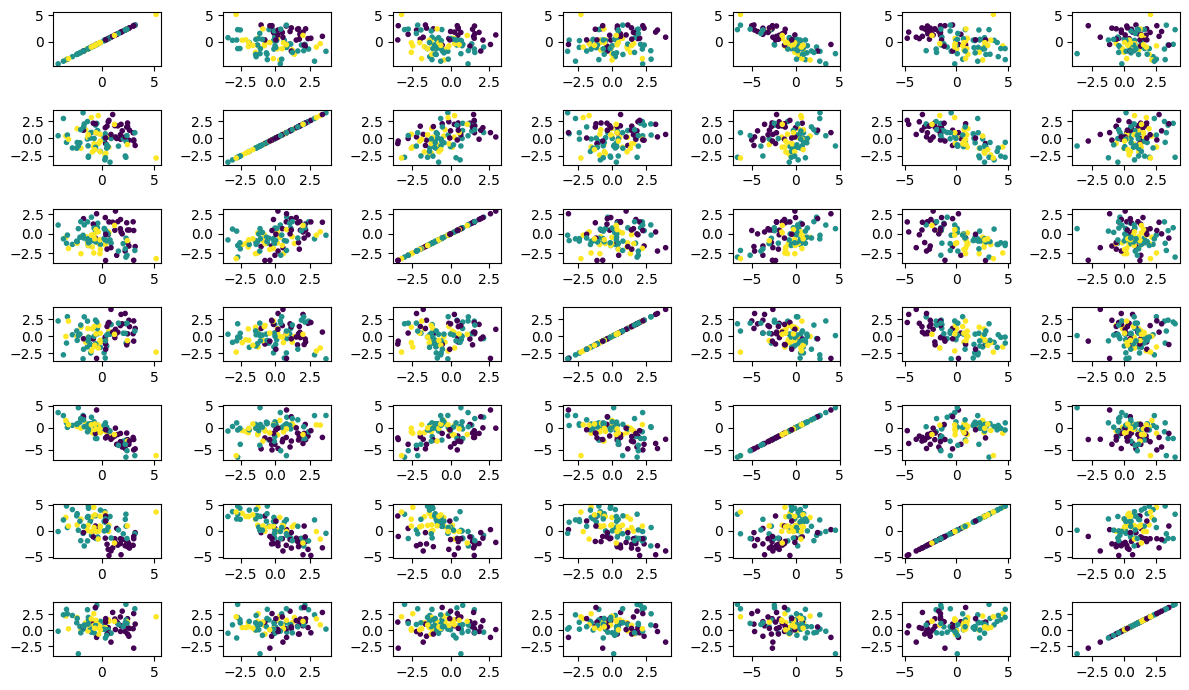

In [25]:
from sklearn.datasets import make_classification

np.random.seed(42)

n_features = 7
dataset_ternary = make_classification(n_classes=3, n_samples=10000,
                                    n_clusters_per_class=3,
                                    n_features=n_features,
                                    n_informative=5,
                                    random_state=42)

x, y = dataset_ternary

fig = plt.figure(figsize=(12, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        plt.scatter(x[:100,i], x[:100,j], c=y[:100], marker='.')
plt.tight_layout()
plt.savefig('cal_1_vis_data_ternary.pdf')

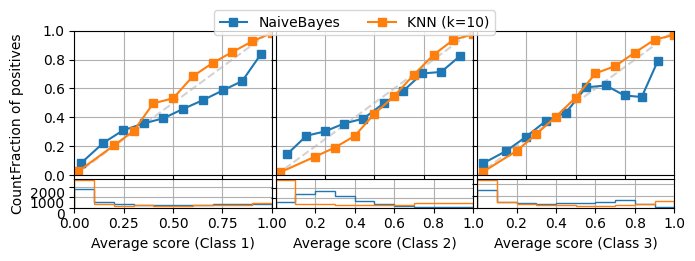

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf_ter = GaussianNB()
clf_ter.fit(x_train, y_train)
clf_ter_2 = KNeighborsClassifier(n_neighbors=10)
clf_ter_2.fit(x_train, y_train)

scores_list = [clf_ter.predict_proba(x_test),
               clf_ter_2.predict_proba(x_test)]

fig = plt.figure(figsize=(8, 2.3))
_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', 'KNN (k=10)'), bins=n_bins,
                            fig=fig)
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_nb_knn_ternary.pdf')

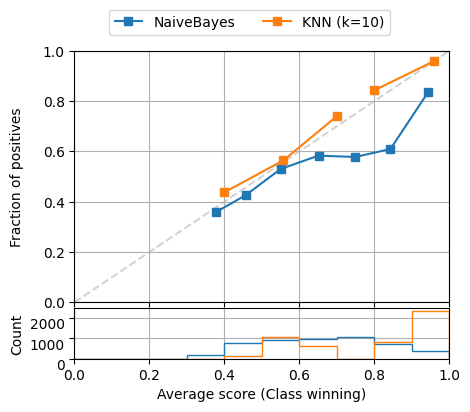

In [27]:
fig = plt.figure()
_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', 'KNN (k=10)'), confidence=True, bins=bins,
                            fig=fig)
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_nb_knn_conf_ternary.pdf',
            bbox_inches='tight')

In the multiclass case we can focus on the most confident score per sample, and plot only the proportion of correct predictions in each bin.

The following plots only show the results for the first classifier.

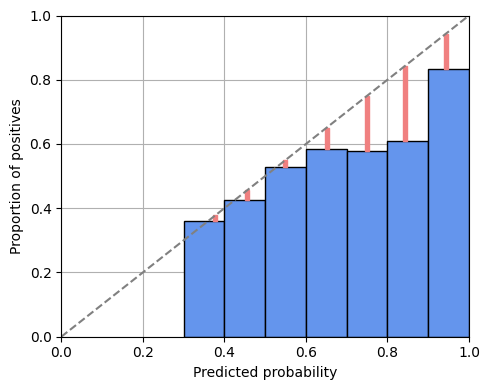

In [28]:
from pycalib.visualisations import plot_multiclass_reliability_diagram_gaps

#x, y = dataset_ternary
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
#clf = GaussianNB()
#clf.fit(x_train, y_train)

probas = clf_ter.predict_proba(x_test)
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=False, n_bins=n_bins)

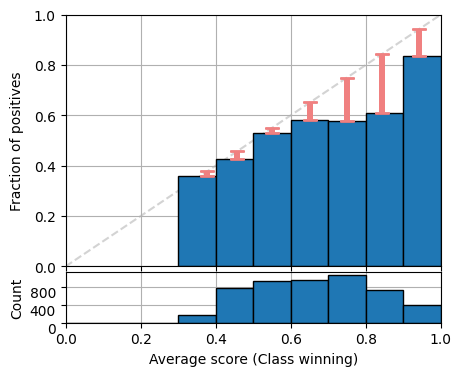

In [29]:
fig = plt.figure()
_ = plot_reliability_diagram(y_test, probas, show_bars=True, show_gaps=True, confidence=True, bins=n_bins, fig=fig)
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_conf_ternary.pdf')

We can compute the confidence-ECE which only computes expected gap size in the previous plot

$$
    \mathsf{confidence{-}ECE}  = \sum_{i=1}^M \frac{|B_{i}|}{N} |\bar{y}(B_{i}) - \bar{p}(B_{i})|
$$

In [30]:
from pycalib.metrics import conf_ECE, conf_MCE

print('Naive Bayes conf-ECE = ', conf_ECE(y_test, probas, bins=n_bins))
print('KNN conf-ECE = ', conf_ECE(y_test, clf_ter_2.predict_proba(x_test), bins=n_bins))

print('Naive Bayes conf-ECE = ', conf_MCE(y_test, probas, bins=n_bins))
print('KNN conf-ECE = ', conf_MCE(y_test, clf_ter_2.predict_proba(x_test), bins=n_bins))

Naive Bayes conf-ECE =  0.10073120102612733
KNN conf-ECE =  0.033760000000003856
Naive Bayes conf-ECE =  0.2332292123860582
KNN conf-ECE =  0.0428745432399551


or the maximum gap with the confidence-MCE:

$$
\mathsf{confidence{-}MCE} = \max_{i \in \{1, \ldots, M\}} |\bar{y}(B_i) - \bar{p}(B_i)|
$$

In [31]:
from pycalib.metrics import conf_MCE

print('conf-MCE = ', conf_MCE(y_test, probas, bins=n_bins))

conf-MCE =  0.2332292123860582


Instead of only showing the most confident prediction, we can show the scores for each class

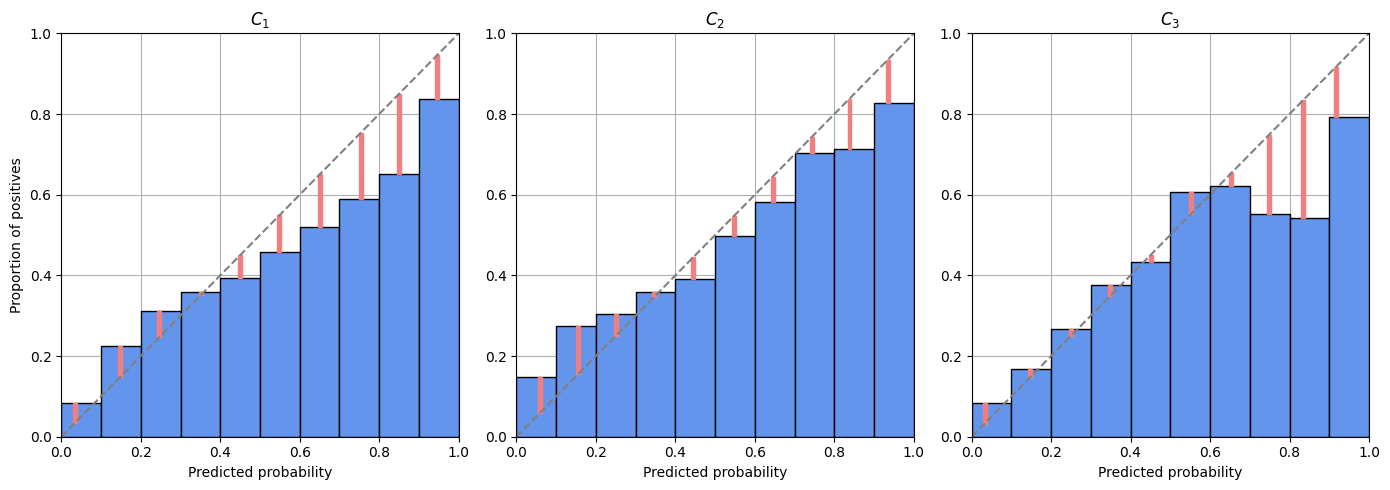

In [32]:
fig = plt.figure(figsize=(14, 5))
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=True, fig=fig, n_bins=n_bins)

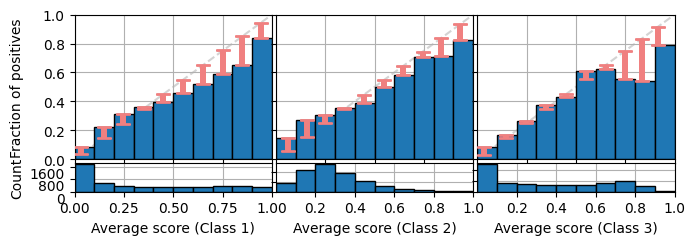

In [33]:
fig = plt.figure(figsize=(8, 2.3))
_ = plot_reliability_diagram(y_test, probas, show_bars=True, show_gaps=True, bins=n_bins,
                             fig=fig)
plt.tight_layout()
#plt.margins(x=0)
plt.savefig('cal_1_vis_rel_dia_ternary.pdf')

With the previous figure we can get an intuition about how the classwise-ECE is computed, as the expected gap size across all the classes

$$
\mathsf{classwise{-}ECE}  = \frac{1}{K}\sum_{j=1}^K \sum_{i=1}^M \frac{|B_{i,j}|}{N} |\bar{y}_j(B_{i,j}) - \bar{p}_j(B_{i,j})|,
$$

In [34]:
from pycalib.metrics import classwise_ECE

print('Naive Bayes classwise-ECE = ', classwise_ECE(y_test, probas, bins=n_bins))
print('KNN classwise-ECE = ', classwise_ECE(y_test, clf_ter_2.predict_proba(x_test), bins=n_bins))

Naive Bayes classwise-ECE =  0.07306931580191046
KNN classwise-ECE =  0.025426666666666653


the classwise-MCE needs to be added, as well as the statistical tests.

# Calibration maps

Calibration maps show the transformation that the calibrator performs to the classifier's scores. This is a map function from $C$ to $C$ where $C$ is the number of classes. In the binary case it is comonly shown for the positive class

## Binary

We will load again the binary dataset that we created earlier

In [35]:
x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

Now we will need a calibrator in order to show the mapping function. We will train here a classifier with a calibrator on top.

In [36]:
from pycalib.models import CalibratedModel, IsotonicCalibration

cal_bin = CalibratedModel(clf_bin, IsotonicCalibration())
cal_bin.fit(x_train, y_train)

CalibratedModel(base_estimator=GaussianNB(), calibrator=IsotonicCalibration())

In the binary case the calibration map corresponds to a 1 to 1 function that can be visualised  in two dimensions with the scores of the classifier in the $x$ axis, and the corresponding probabilities from the calibrator in the $y$ axis.

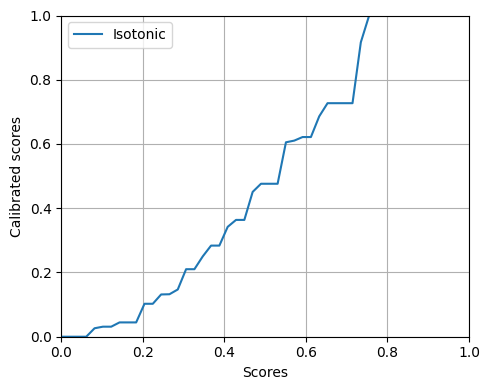

In [37]:
scores_linspace = np.linspace(0, 1, 50)
scores_linspace = np.vstack((1-scores_linspace, scores_linspace)).T
fig = plt.figure()
ax = fig.add_subplot(111)
calibrated = cal_bin.calibrator.predict_proba(scores_linspace)
ax.plot(scores_linspace[:, 1], calibrated[:, 1], label='Isotonic')
ax.legend()
ax.set_xlabel('Scores')
ax.set_ylabel('Calibrated scores')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plt.tight_layout()
plt.savefig('cal_1_vis_cal_map_binary.pdf')

Notice the similarity to the reliability diagram of the classifier, as the calibrator is trying to correct the misscalibration by fitting the scores as best as possible.

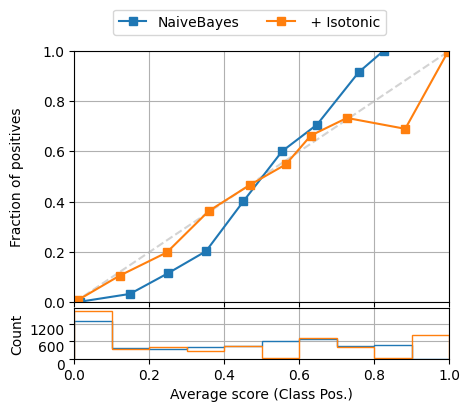

In [38]:
fig = plt.figure()
_ = plot_reliability_diagram(y_test, [cal_bin.base_estimator.predict_proba(x_test),
                                      cal_bin.predict_proba(x_test)],
                             legend=('NaiveBayes', ' + Isotonic'), class_names=['Neg.', 'Pos.'],
                             bins=n_bins, fig=fig)
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_cal_map_nb_binary.pdf')

Accuracy  0.843
Correct =  486
Incorrect =  19
Accuracy =  0.9623762376237623


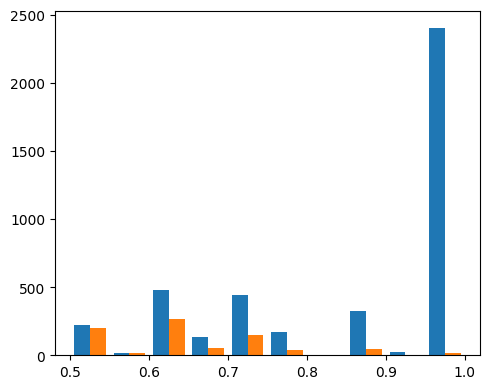

In [39]:
aux_scores = cal_bin.predict_proba(x_test)
aux_prediction = np.argmax(aux_scores, axis=1)
accuracy = np.mean(aux_prediction == y_test)
print('Accuracy ', accuracy)
aux_confidence = np.max(aux_scores, axis=1)
idx_correct = aux_prediction == y_test
idx_incorrect = aux_prediction != y_test
plt.hist([aux_confidence[idx_correct], aux_confidence[idx_incorrect]])
#plt.hist(aux_confidence)
aux_bin = [0.9, 1.0]
aux_indices = (aux_confidence > aux_bin[0]) & (aux_confidence < aux_bin[1])
aux_correct = np.sum(aux_prediction[aux_indices] == y_test[aux_indices])
aux_incorrect = np.sum(aux_prediction[aux_indices] != y_test[aux_indices])
print('Correct = ', aux_correct)
print('Incorrect = ', aux_incorrect)
print('Accuracy = ', aux_correct/(aux_correct + aux_incorrect))

In [40]:
cal_bin.predict_proba(x_test).shape
y_test.shape

(5000,)

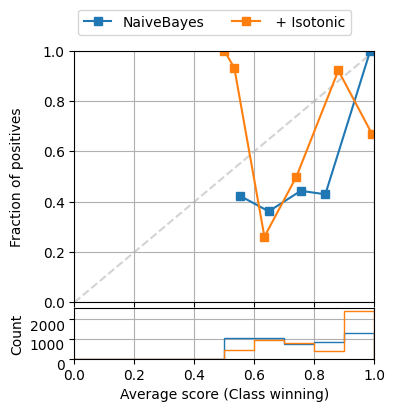

In [41]:
_ = plot_reliability_diagram(y_test, [cal_bin.base_estimator.predict_proba(x_test),
                                      cal_bin.predict_proba(x_test)],
                             legend=('NaiveBayes', ' + Isotonic'), class_names=['Neg.', 'Pos.'],
                             bins=n_bins, confidence=True)
plt.tight_layout()
plt.savefig('cal_1_vis_rel_dia_cal_map_nb_conf_binary.pdf')

In [42]:
print('Naive Bayes bin-ECE = ', binary_ECE(y_test, cal_bin.base_estimator.predict_proba(x_test)[:,1], bins=n_bins))
print('+ Isotonic bin-ECE = ', binary_ECE(y_test,  cal_bin.predict_proba(x_test)[:,1], bins=n_bins))

print('Naive Bayes bin-MCE = ', binary_MCE(y_test, cal_bin.base_estimator.predict_proba(x_test)[:,1], bins=n_bins))
print('+ Isotonic bin-MCE = ', binary_MCE(y_test,  cal_bin.predict_proba(x_test)[:,1], bins=n_bins))

print('Naive Bayes conf-ECE = ', conf_ECE(y_test, cal_bin.base_estimator.predict_proba(x_test), bins=n_bins))
print('+ Isotonic conf-ECE = ', conf_ECE(y_test,  cal_bin.predict_proba(x_test), bins=n_bins))

print('Naive Bayes conf-MCE = ', conf_MCE(y_test, cal_bin.base_estimator.predict_proba(x_test), bins=n_bins))
print('+ Isotonic conf-MCE = ', conf_MCE(y_test,  cal_bin.predict_proba(x_test), bins=n_bins))

Naive Bayes bin-ECE =  0.079496190619477
+ Isotonic bin-ECE =  0.01156162517476712
Naive Bayes bin-MCE =  0.1753553512921694
+ Isotonic bin-MCE =  0.19255158274553785
Naive Bayes conf-ECE =  0.07949619061947717
+ Isotonic conf-ECE =  0.009154236420034963
Naive Bayes conf-MCE =  0.1491809427878793
+ Isotonic conf-MCE =  0.5


## Ternary Calibration maps

It is possible to visualise a calibration map for ternary classification problems. We will start by loading the ternary dataset, and training a classifier and a calibrator on top.

In [43]:
from dirichletcal import FullDirichletCalibrator
from pycalib.metrics import classwise_MCE

x, y = dataset_ternary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal_ter = CalibratedModel(clf_ter, FullDirichletCalibrator())
cal_ter.fit(x_train, y_train)

print('Naive Bayes confidence-ECE = ', conf_ECE(y_test, clf_ter.predict_proba(x_test), bins=n_bins))
print('+ Dirichlet confidence-ECE = ', conf_ECE(y_test, cal_ter.predict_proba(x_test), bins=n_bins))

print('Naive Bayes confidence-MCE = ', conf_MCE(y_test, clf_ter.predict_proba(x_test), bins=n_bins))
print('+ Dirichlet confidence-MCE = ', conf_MCE(y_test, cal_ter.predict_proba(x_test), bins=n_bins))

print('Naive Bayes classwise-ECE = ', classwise_ECE(y_test, clf_ter.predict_proba(x_test), bins=n_bins))
print('+ Dirichlet classwise-ECE = ', classwise_ECE(y_test, cal_ter.predict_proba(x_test), bins=n_bins))

print('Naive Bayes classwise-MCE = ', classwise_MCE(y_test, clf_ter.predict_proba(x_test), bins=n_bins))
print('+ Dirichlet classwise-MCE = ', classwise_MCE(y_test, cal_ter.predict_proba(x_test), bins=n_bins))

ModuleNotFoundError: No module named 'dirichletcal'

With 3 classes the calibration map corresponds to a function from 3 to 3 dimensions. As this is difficult to visualise we propose several approaches that show part of the map.

We will first obtain a 2D mesh in the simplex, trying to cover most of the space

In [ ]:
from pycalib.visualisations.barycentric import get_mesh_bc
P_bc_grid = get_mesh_bc(subdiv=4)

Now we will obtain the predicted probabilities output by our calibrator for each of the points in the mesh.

In [ ]:
calibrated = cal_ter.calibrator.predict_proba(P_bc_grid)

One way is to consider that the input and output scores live in a 2D simplex. This means that we can visualise the mapping from an input and output scores as a 2D coordinates. Then we will show both coordinates as the begining and end of an arrow.

In [ ]:
from pycalib.visualisations.barycentric import draw_calibration_map

fig = plt.figure(figsize=(3, 3))
_ = draw_calibration_map(P_bc_grid, calibrated,  subdiv=4, fig=fig)
plt.tight_layout()
plt.savefig('cal_1_vis_cal_map_ternary.pdf')

We can also paint the arrows in three different colors, one per class. We will paint them indicating the most confident class at the tip of the arrow (output of the calibrator).

In [ ]:
color_list = ['Red', 'Orange', 'Blue']
color = [color_list[i] for i in calibrated.argmax(axis=1).astype(int)]

fig = plt.figure(figsize=(3, 3))
_ = draw_calibration_map(P_bc_grid, calibrated, color=color,  subdiv=4, fig=fig)
plt.tight_layout()
plt.savefig('cal_1_vis_cal_map_ternary_color.pdf')

Another way is to show 3 calibration maps from 3 to 1 dimension. Each calibration map shows the full input score to the calibrator, and only one of the classes' output. The input then will be shown as the position in a 2D simplex, while the output is shown as a heatmap.

In [ ]:
from pycalib.visualisations.ternary import draw_func_contours, plot_converging_lines_pvalues, get_converging_lines

cmap_list = ['Reds', 'Oranges', 'Blues']

fig = plt.figure(figsize=(8, 3))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal_ter.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels=['$C_1$', '$C_2$', '$C_3$'], fig=fig, ax=ax, cmap=cmap_list[i])
plt.tight_layout()
plt.savefig('cal_1_vis_rel_diag_ternary.pdf')

Notice that we can cut arbitrary sections on the previous calibration maps and obtain cross-sections that can be visualised as binary calibration maps.

In [ ]:
from pycalib.visualisations.ternary import plot_converging_lines_pvalues, get_converging_lines

fig = plt.figure(figsize=(8, 5))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)

    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal_ter.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels=['$C_1$', '$C_2$', '$C_3$'], fig=fig, ax=ax, cmap=cmap_list[i],
                       nlevels=100, subdiv=4, draw_lines=5, class_index=i)

    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=20, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)
plt.tight_layout()
plt.savefig('cal_1_vis_rel_diag_ternary_lines.pdf')

In the following figure we show side by side the previous calibration maps

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 4, 1)
fig = draw_calibration_map(P_bc_grid, calibrated, color=color, subdiv=5, fig=fig, ax=ax, alpha=0.9)

for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(1, 4, i+2)
    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal_ter.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels=['$C_1$', '$C_2$', '$C_3$'], fig=fig, ax=ax, cmap=cmap_list[i])